# RNA PreProcessing & Random Forest Prediction model.

In [1]:
#Load necessary libraries

import re
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Expression Data Preparation

In [3]:
# Loads data: 
df = pd.read_csv("log2FPKM.tsv", sep = "\t")

# Data inspection:
df.head()

# Index data by gene_id
df = df.set_index("00gene_id")

In [4]:
# Check for NA values
df.isna().sum().head()

NB001    0
NB002    0
NB003    0
NB004    0
NB005    0
dtype: int64

In [5]:
# Duplicated gene_ids check:

df.index.duplicated().sum()

0

In [6]:
# Removing genes with zero expression:

all_zero_genes = (df == 0).all(axis = 1)
all_zero_genes

00gene_id
1/2-SBSRNA4    False
A1BG           False
A1BG-AS1       False
A1CF           False
A2LD1          False
               ...  
ZYG11A         False
ZYG11B         False
ZYX            False
ZZEF1          False
ZZZ3           False
Length: 23146, dtype: bool

In [7]:
# Filtering out genes with lower than 20% expression:

# Checking rows and columns.
df.shape 

# Filtering out the lowly expressed genes.
low_expr = int(0.2 * df.shape[1])
df = df[(df > 0).sum(axis = 1) >= low_expr]

# Rechecking rows and columns.
df.shape

(19713, 498)

In [8]:
# Filtering out genes with constant variance:
gene_varience = df.var(axis = 1)
df = df[ gene_varience > 0.1]
df.shape

(15012, 498)

In [9]:
# Transpose data for ML

X_rna = df.T
X_rna.shape

(498, 15012)

In [10]:
# check IDs match prior to intersection 
import re

pattern = r"^NB\d{3}$"   

matches = X_rna.index.to_series().str.match(pattern)

print("All IDs valid:", matches.all())
print("Invalid IDs:", (~matches).sum())


All IDs valid: False
Invalid IDs: 330


In [11]:
#Identifying mismatched gene_ids

invalid_ids = X_rna.index[~matches]
invalid_ids[:20]

Index(['NB013_BC02FPACXX_L1_CGATGT', 'NB014_BC02FPACXX_L1_TGACCA',
       'NB015_BC02FPACXX_L1_ACAGTG', 'NB016_BC02FPACXX_L1_GCCAAT',
       'NB017_BC02FPACXX_L1_CAGATC', 'NB018_BC02FPACXX_L1_CTTGTA',
       'NB019_BC02FPACXX_L2_CGATGT', 'NB020_BC02FPACXX_L2_TGACCA',
       'NB021_BC02FPACXX_L2_ACAGTG', 'NB022_BC02FPACXX_L2_GCCAAT',
       'NB023_BC02FPACXX_L2_CAGATC', 'NB024_BC02FPACXX_L2_CTTGTA',
       'NB025_BC02FPACXX_L3_CGATGT', 'NB026_BC02FPACXX_L3_TGACCA',
       'NB027_BC02FPACXX_L3_ACAGTG', 'NB028_BC02FPACXX_L3_GCCAAT',
       'NB029_BC02FPACXX_L3_CAGATC', 'NB030_BC02FPACXX_L3_CTTGTA',
       'NB031_BC02FPACXX_L4_CGATGT', 'NB032_BC02FPACXX_L4_TGACCA'],
      dtype='object')

In [12]:
# Extract NB prefix to fix sample IDs
X_rna.index = (
    X_rna.index
    .astype(str)
    .str.extract(r"^(NB\d{3})")[0]
)

In [13]:
#Rechecks valid IDs
matches = X_rna.index.to_series().str.match(r"^NB\d{3}$")

print("All IDs valid:", matches.all())
print("Valid IDs:", matches.sum())

All IDs valid: True
Valid IDs: 498


In [14]:
# Load metadata- patient info
df_patient_info = pd.read_csv("patientInfo.tsv",sep='\t').set_index('ID')
df_patient_info.columns.name = 'FactorValues'
df_patient_info.head()
df_patient_info.sort_index()

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB001,male,987,1.0,1.0,4,1.0
NB002,male,1808,NaN,NaN,NaN,NaN
NB003,female,625,1.0,1.0,4,1.0
NB004,female,335,NaN,NaN,NaN,NaN
NB005,female,536,1.0,1.0,4,1.0
...,...,...,...,...,...,...
NB494,male,56,NaN,NaN,NaN,NaN
NB495,male,163,0.0,0.0,1,0.0
NB496,male,132,NaN,NaN,NaN,NaN


In [15]:
# Load patient-level clinical metadata
# Training/validation and independent test cohorts
meta_train_val = pd.read_csv("patientInfo_train.tsv", sep="\t", index_col=0)
meta_test  = pd.read_csv("patientInfo_test.tsv",  sep="\t", index_col=0)

In [16]:
# Align RNA and metadata
common_train_val= X_rna.index.intersection(meta_train_val.index)

### Endpoint Definition

In [18]:

# Map endpoint columns
endpoint_map = {}
for col in meta_train_val.columns:
    if "inss.stage" in col:
        endpoint_map["stage"] = col
    elif "death.from.disease" in col:
        endpoint_map["death"] = col
    elif "high.risk" in col:
        endpoint_map["risk"] = col
    elif "progression" in col:
        endpoint_map["progression"] = col

In [19]:
#Ensure stages map back to original labels 
stage_series = meta_train_val.loc[
    common_train_val,
    endpoint_map["stage"]
].astype("category")

stage_labels = list(stage_series.cat.categories)
print(stage_labels)

['1', '2', '3', '4', '4S']


In [20]:
#Build y as per each of the 4 endpoints

y = {}
for name, col in endpoint_map.items():
    y_tmp = meta_train_val.loc[common_train_val, col]

    if name == "stage":
        y[name] = y_tmp.astype("category").cat.codes
    else:
        y[name] = y_tmp.astype(int)

### Train–Validation Split

In [21]:
# Select RNA samples with matching metadata for modelling
X = X_rna.loc[common_train_val]

In [22]:
# Split indices
train_idx, val_idx = train_test_split(
    X.index,
    test_size=0.20,
    random_state=42
)

# Apply split
X_train = X.loc[train_idx]
X_val   = X.loc[val_idx]

y_train = {name: y[name].loc[train_idx] for name in y}
y_val   = {name: y[name].loc[val_idx]   for name in y}

In [23]:
# Test cohort

common_test = X_rna.index.intersection(meta_test.index)
X_test = X_rna.loc[common_test]

In [24]:
# Identify how many samples are in each stage.
print(stage_series.value_counts())

FactorValue..inss.stage.
4     91
1     60
2     40
3     30
4S    28
Name: count, dtype: int64


### Random Forest Model Training

In [25]:
# Train each RF per endpoint

models = {}

for name in y_train:
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    )
    rf.fit(X_train, y_train[name])
    models[name] = rf

### Global Feature Importance Identification and Plotting

In [26]:
# Dictionary to store top 5 features per endpoint
top_features = {}

for endpoint, model in models.items():
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame of features and their importances
    feat_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })

    # Sort by importance descending and take top 5
    top5 = feat_df.sort_values(by="Importance", ascending=False).head(5)
    top_features[endpoint] = top5

# Show top 5 for each endpoint
for endpoint, df in top_features.items():
    print(f"\nTop 5 features for {endpoint}:\n", df)


Top 5 features for death:
       Feature  Importance
11265    RRM1    0.006589
4178   EXOSC9    0.005623
10006   POLE3    0.004871
8467   MYO18A    0.004714
5798   HNRNPL    0.004601

Top 5 features for risk:
       Feature  Importance
2572     CHD5    0.007873
8064    MINK1    0.007802
6155    INPP1    0.007700
14009     UNG    0.007244
14285   WDR89    0.006875

Top 5 features for stage:
       Feature  Importance
10349  PRSS35    0.001511
9652   PGM2L1    0.001509
55      ABCG4    0.001328
322       AGT    0.001312
3712     DRGX    0.001301

Top 5 features for progression:
             Feature  Importance
11265          RRM1    0.004511
10057          POP4    0.003717
6978   LOC100130691    0.002419
3476           DHFR    0.002362
13866          TYMS    0.002200


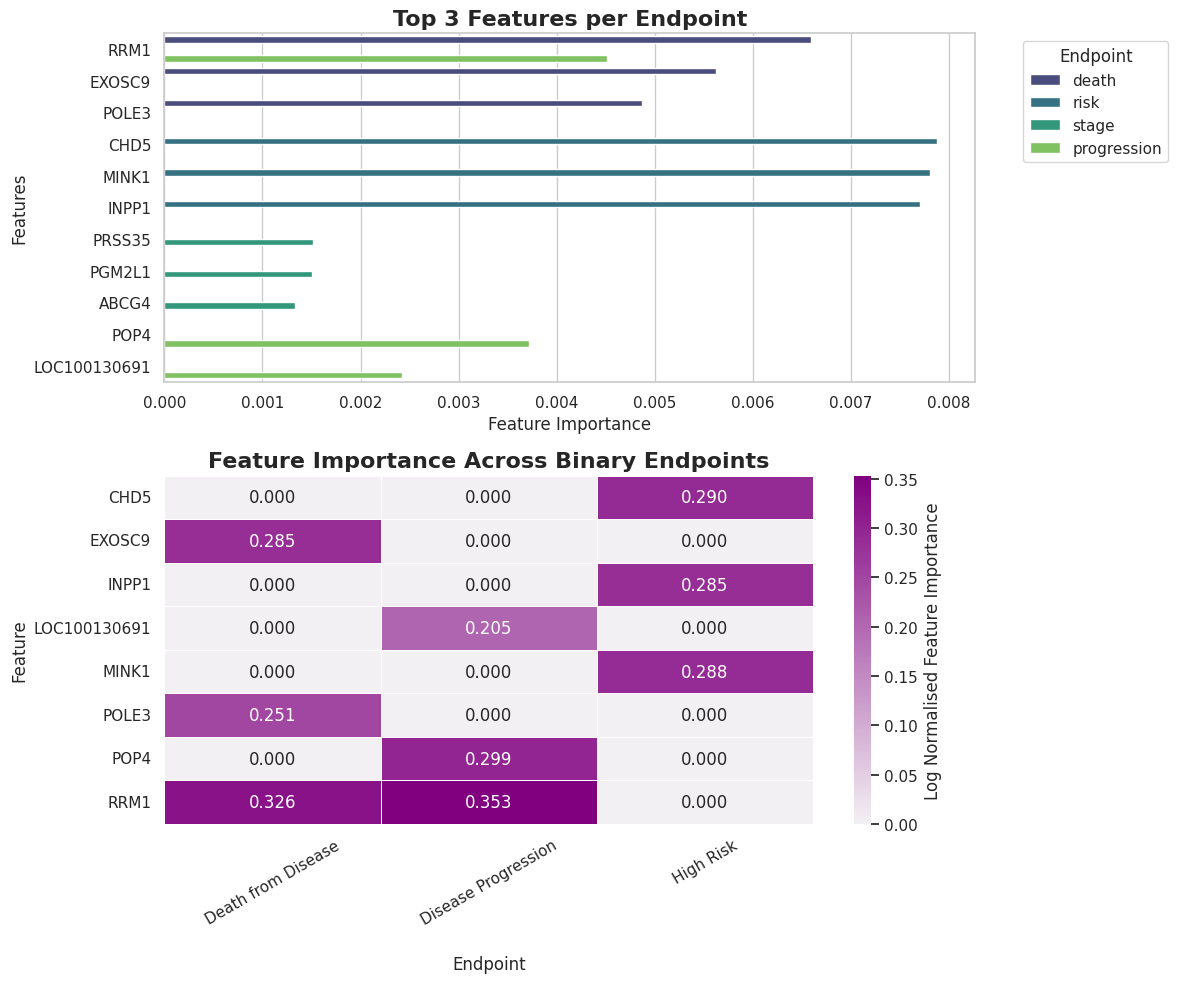

In [27]:
# Reduce top_features to top 3 features per endpoint
top3_features = {endpoint: df.sort_values("Importance", ascending=False).head(3) 
                 for endpoint, df in top_features.items()}

# Combine into a single DataFrame for plotting
plot_df = pd.concat(
    [df.assign(Endpoint=endpoint) for endpoint, df in top3_features.items()],
    ignore_index=True
)

# Pivot for heatmap
heatmap_df = plot_df.pivot(index='Feature', columns='Endpoint', values='Importance').fillna(0)

# Set style for heatmap
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]})

# Bar plot overlay
palette = sns.color_palette("viridis", n_colors=heatmap_df.shape[1])
sns.barplot(
    data=plot_df,
    x="Importance",
    y="Feature",
    hue="Endpoint",
    palette=palette,
    ax=axes[0]
)

axes[0].set_title("Top 3 Features per Endpoint", fontsize=16, weight="bold")
axes[0].set_xlabel("Feature Importance", fontsize=12)
axes[0].set_ylabel("Features", fontsize=12)
axes[0].legend(title="Endpoint", bbox_to_anchor=(1.05, 1), loc='upper left')


# Remove the stage endpoint
heatmap_df = heatmap_df.drop(columns=["stage"], errors='ignore')

# Rename endpoints
heatmap_df = heatmap_df.rename(columns={
    "death": "Death from Disease",
    "progression": "Disease Progression",
    "risk": "High Risk"
})


pastel_cmap = sns.light_palette("purple", as_cmap=True) 

nonzero = heatmap_df.loc[(heatmap_df != 0).any(axis=1)]

heatmap_scaled = nonzero / nonzero.sum()
heatmap_log = np.log1p(heatmap_scaled)


sns.heatmap(
    heatmap_log,
    annot=True,
    fmt=".3f",
    cmap=pastel_cmap,
    linewidths=0.5,
    cbar_kws={'label': 'Log Normalised Feature Importance'},
    ax=axes[1]
)

# Colourmap for aesthetics
pastel_cmap = sns.light_palette("purple", as_cmap=True)  


# Set titles and labels
axes[1].set_title("Feature Importance Across Binary Endpoints", fontsize=16, weight="bold")
axes[1].set_xlabel("Endpoint", fontsize=12, labelpad=20) 
axes[1].set_ylabel("Feature", fontsize=12)
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig(
    "Feature_importance.pdf",
    bbox_inches="tight"
)
plt.show()

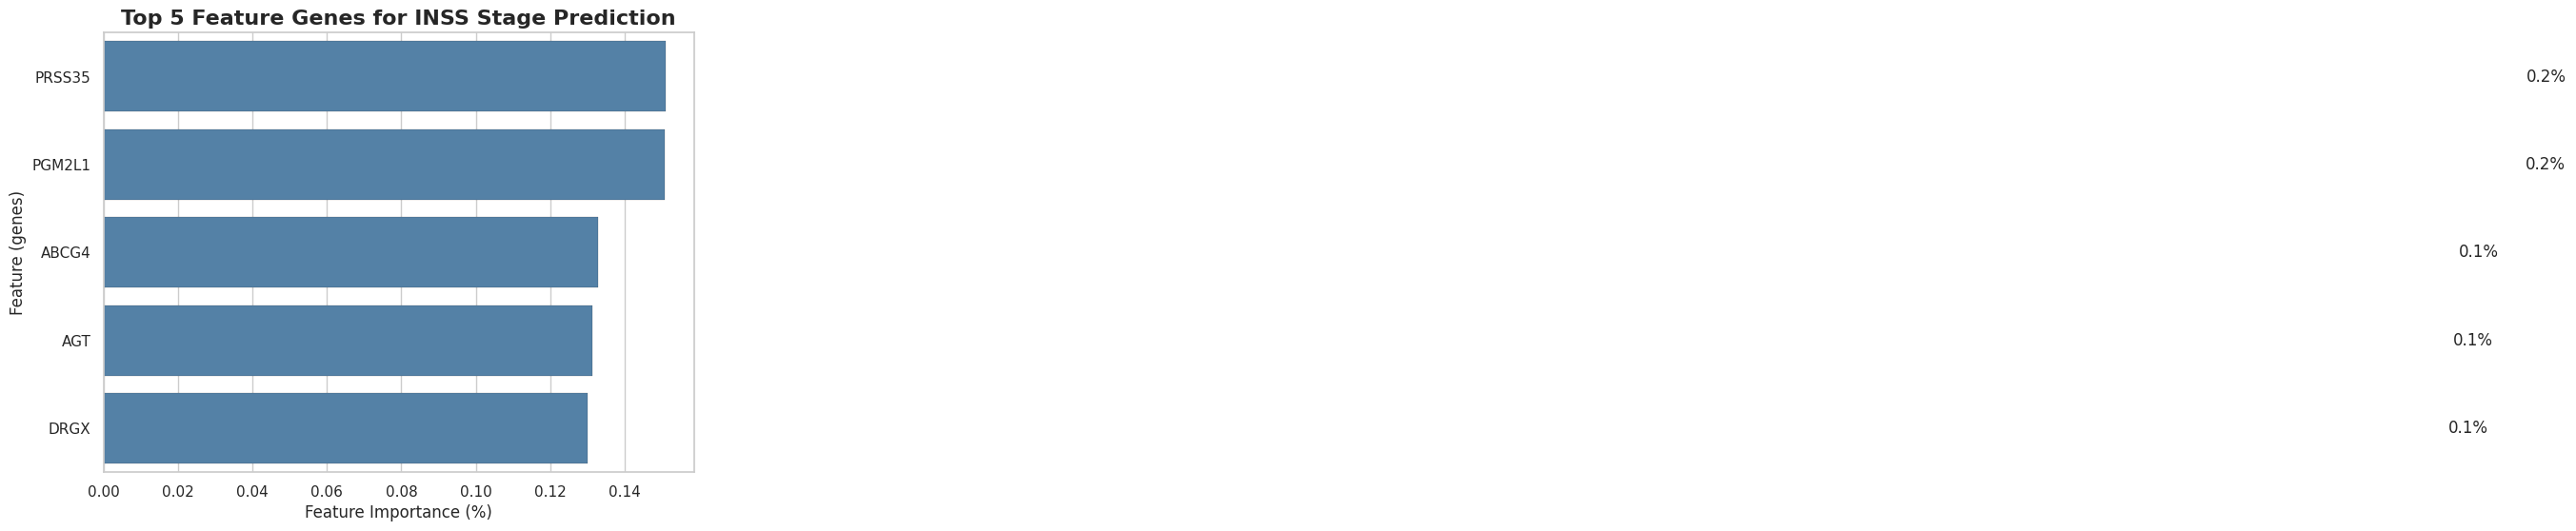

In [28]:

# Reduce top_features to top 5 features per endpoint
top10_features = {endpoint: df.sort_values("Importance", ascending=False).head(5) 
                  for endpoint, df in top_features.items()}

# Combine into a single DataFrame for plotting
plot_df = pd.concat(
    [df.assign(Endpoint=endpoint) for endpoint, df in top10_features.items()],
    ignore_index=True
)

# Filter for INSS stage only
plot_df = plot_df[plot_df['Endpoint'] == 'stage'].copy()

# Reset index to avoid y-coordinate issues
plot_df.reset_index(drop=True, inplace=True)

# Convert importance to percentage
plot_df['Importance_pct'] = plot_df['Importance'] * 100


# Plot horizontal bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))  

#Bar plot
barplot = sns.barplot(
    data=plot_df,
    x="Importance_pct",
    y="Feature",
    color="steelblue",
    edgecolor="black",
    linewidth=0.1
)

# Add percentage labels at the end of bars
for idx, row in plot_df.iterrows():
    barplot.text(
        row['Importance_pct'] + 0.5, 
        idx,                           
        f"{row['Importance_pct']:.1f}%",
        va='center'
    )

plt.title("Top 5 Feature Genes for INSS Stage Prediction", fontsize=16, weight="bold")
plt.xlabel("Feature Importance (%)", fontsize=12)
plt.ylabel("Feature (genes)", fontsize=12)

#Figure showing percentage contribution for top 5 global important features for INSS Stage 
plt.savefig("Top10_genes_stage.pdf")
plt.show()

In [29]:
# Sanity checks

print("RNA-seq train samples:", X_train.shape[0])
print("RNA-seq val samples:", X_val.shape[0])
print("RNA-seq test samples:", X_test.shape[0])

for name in y_train:
    print(f"{name}: train={y_train[name].shape}, val={y_val[name].shape}")

RNA-seq train samples: 199
RNA-seq val samples: 50
RNA-seq test samples: 249
death: train=(199,), val=(50,)
risk: train=(199,), val=(50,)
stage: train=(199,), val=(50,)
progression: train=(199,), val=(50,)


In [30]:
for name in y_train:
    print(name)
    print(y_train[name].value_counts(normalize=True))

death
FactorValue..death.from.disease.
0    0.788945
1    0.211055
Name: proportion, dtype: float64
risk
FactorValue..high.risk.
0    0.653266
1    0.346734
Name: proportion, dtype: float64
stage
3    0.371859
0    0.226131
1    0.165829
4    0.125628
2    0.110553
Name: proportion, dtype: float64
progression
FactorValue..progression.
0    0.61809
1    0.38191
Name: proportion, dtype: float64


### Model Evaluation - Binary Endpoints

In [31]:
# Accuracy for Binary Endpoints
for name in ["death", "risk", "progression"]:
    if name not in models:
        continue

    y_prob = models[name].predict_proba(X_val)[:, 1]
    y_pred = models[name].predict(X_val)

    auc = roc_auc_score(y_val[name], y_prob)
    acc = accuracy_score(y_val[name], y_pred)

    print(f"{name}")
    print(f"  AUC: {auc * 100:.1f}%")
    print(f"  Accuracy: {acc * 100:.1f}%")

death
  AUC: 91.5%
  Accuracy: 86.0%
risk
  AUC: 96.6%
  Accuracy: 94.0%
progression
  AUC: 88.7%
  Accuracy: 84.0%


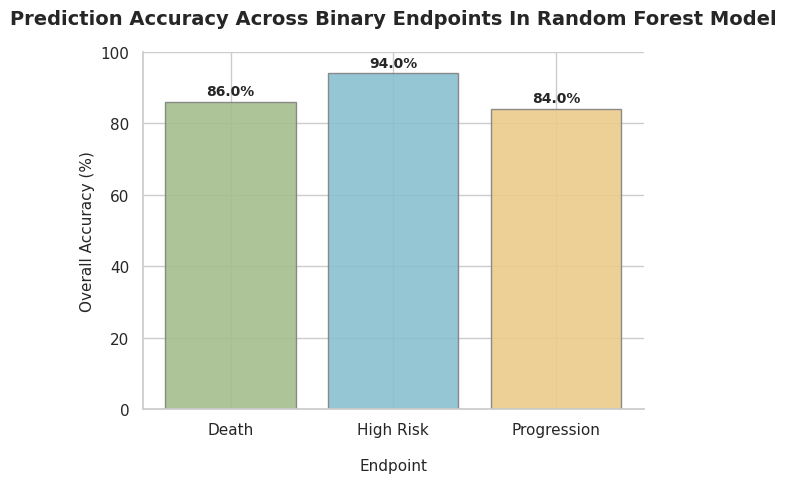

In [42]:
# Overall accuracies for each endpoint
accuracy_data = pd.DataFrame({
    "Endpoint": ["Death", "High Risk", "Progression"],
    "Accuracy": [86.0, 94.0, 84.0]  # percentages
})

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

# Colour palette
colors = ["#A3BE8C", "#88C0D0", "#EBCB8B"] 

# Bar plot
bars = plt.bar(
    accuracy_data["Endpoint"],
    accuracy_data["Accuracy"],
    color=colors,
    alpha=0.9,
    edgecolor="gray"
)

# Accuracy labels on top of each bar for easy viewing 
for bar, acc in zip(bars, accuracy_data["Accuracy"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{acc:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Axes labels
plt.ylabel("Overall Accuracy (%)", fontsize=11, fontweight="medium")
plt.xlabel("Endpoint", fontsize=11, fontweight="medium", labelpad=15)
plt.title("Prediction Accuracy Across Binary Endpoints In Random Forest Model", fontsize=14, fontweight="bold", pad=20)
sns.despine()

# Set y-axis limit
plt.ylim(0, 100)

# Adjust layout
plt.tight_layout()
plt.savefig(
    "accuracy_of_predictions.pdf",
    bbox_inches="tight"
)
plt.show()


### Model Evaluation - Categorical Endpoints

In [32]:
#Accuracy for catergorical data- stage.
from sklearn.metrics import classification_report
y_pred_stage = models["stage"].predict(X_val)

report = classification_report(
    y_val["stage"],
    y_pred_stage,
    target_names=stage_labels,
    output_dict=True
)

stage_acc = (
    pd.DataFrame(report)
    .T
    .loc[stage_labels, "recall"]
    * 100
)

In [33]:
#Computing stagewise accuracy to identify differences in classes.

print("Stage-wise accuracy (recall):")
for stage, acc in stage_acc.items():
    print(f"  Stage {stage}: {acc:.1f}%")

Stage-wise accuracy (recall):
  Stage 1: 66.7%
  Stage 2: 42.9%
  Stage 3: 12.5%
  Stage 4: 88.2%
  Stage 4S: 33.3%


In [34]:
#Compute ROC-AUC accuracy for statistics
y_proba_stage = models["stage"].predict_proba(X_val)

roc_auc = roc_auc_score(
    y_val["stage"],
    y_proba_stage,
    multi_class="ovr",
    average="weighted"
)

print(roc_auc * 100)


78.08987407117047


In [35]:
# Computing per stage accuracys

y_pred_stage = models["stage"].predict(X_val)

cm = confusion_matrix(y_val["stage"], y_pred_stage)

per_stage_acc = cm.diagonal() / cm.sum(axis=1)
per_stage_support = cm.sum(axis=1)

stage_df = pd.DataFrame({
    "Stage": stage_labels,
    "Accuracy": per_stage_acc * 100,
    "Support": per_stage_support
})


In [37]:
# Compute normalised confusion matrix for stage predictions
y_pred_stage = models["stage"].predict(X_val)
cm = confusion_matrix(y_val["stage"], y_pred_stage)

# Normalise by true class.
cm_norm = cm / cm.sum(axis=1, keepdims=True)

### Confusion Matrix for INSS stage

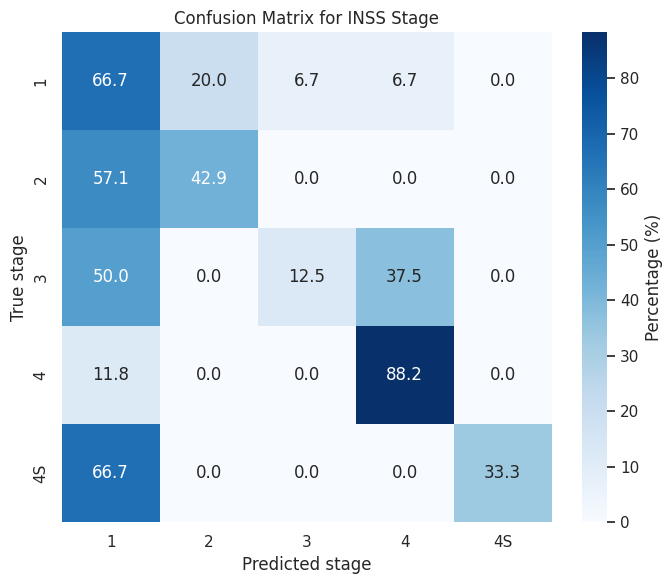

In [38]:
plt.figure(figsize=(7, 6))

#Heatmap overlay 
sns.heatmap(
    cm_norm * 100,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=stage_labels,
    yticklabels=stage_labels,
    cbar_kws={"label": "Percentage (%)"}
)

plt.xlabel("Predicted stage")
plt.ylabel("True stage")
plt.title("Confusion Matrix for INSS Stage")
plt.tight_layout()

plt.savefig(
    "stage_normalised_confusion_matrix.pdf",
    bbox_inches="tight"
)
plt.show()

In [39]:
#Calculating stage 4 accuracy: highest accuracy across stages
stage4_acc = cm[3, 3] / cm[3].sum()
print("Stage 4 accuracy:", stage4_acc * 100)

Stage 4 accuracy: 88.23529411764706


In [40]:
#Global classification stats for stage prediction
print(classification_report(y_val["stage"], y_pred_stage, target_names=stage_labels))

              precision    recall  f1-score   support

           1       0.45      0.67      0.54        15
           2       0.50      0.43      0.46         7
           3       0.50      0.12      0.20         8
           4       0.79      0.88      0.83        17
          4S       1.00      0.33      0.50         3

    accuracy                           0.60        50
   macro avg       0.65      0.49      0.51        50
weighted avg       0.61      0.60      0.57        50



In [41]:
#Identifying top features for stage 4 for analysis on known gene contributions in neuroblastoma.

stage = 4  

mask = y_val["stage"] == stage

stage_mean = X_val[mask].mean(axis=0)
other_mean = X_val[~mask].mean(axis=0)

diff = (stage_mean - other_mean).abs()

top4_stage4 = diff.nlargest(4)

print(top4_stage4)

00gene_id
MIR5047    10.028152
PRAME       4.336948
CALB1       3.897777
MIR3911     3.789425
dtype: float64
